In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os, re
import matplotlib.colors as mcolors
def find_closest(value, series):
    return series.iloc[(series - value).abs().argsort()[:1]].values[0]

### Plot REF Cu (10 um)

001_Cu-6Sm_Pristine_RT_1
001_Cu-6Sm_Pristine_RT_2
002_Cu-6Sm_Activation_ramp_2
003_Cu-6Sm_Activation_dwell_1
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_1
005_Cu-6Sm_Reaction_T1_2
006_Cu-6Sm_Ramp_T1T2_2
007_Cu-6Sm_Reaction_T2_1
007_Cu-6Sm_Reaction_T2_2
008_Cu-6Sm_Ramp_T2T3_2
009_Cu-6Sm_Reaction_T3_1
010_Cu-6Sm_Ramp_T3T4_2
011_Cu-6Sm_Reaction_T4_1
012_Cu-6Sm_Ramp_T4T5_2
013_Cu-6Sm_Reaction_T5_1
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_2


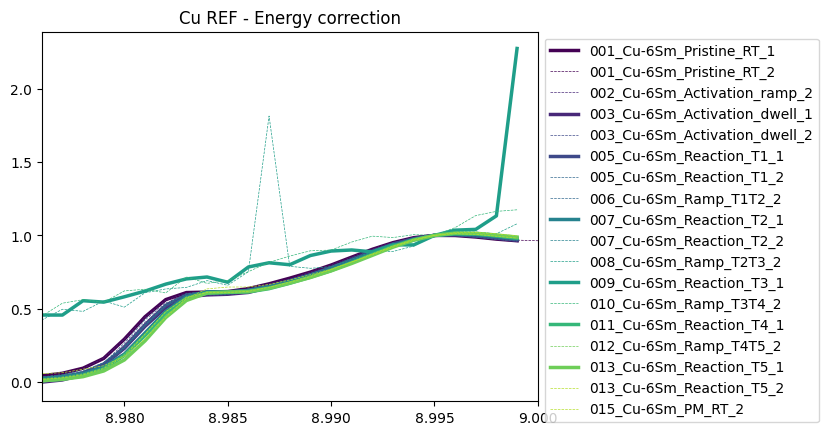

In [3]:
search_string = "Cu_REF_merged"
var1="ionch1" # diode1 / roiX
var2="mcaRt" # AS_IC / mcaLt

monoE_min = 8.96
monoE_max = 8.9955

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Cu_REF_list = []
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    target_value = 0.5
    idx_before = result_df[result_df["I_norm"] <= target_value].index[-1]
    idx_after = result_df[result_df["I_norm"] > target_value].index[0]
    x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Cu_REF_list.append((label,interpolated_monoE))


    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
#plt.ylim([1.75,2.93])
plt.xlim([8.976,9.])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Cu REF - Energy correction")

plt.savefig('Cu_REF_NEXAFS.png')

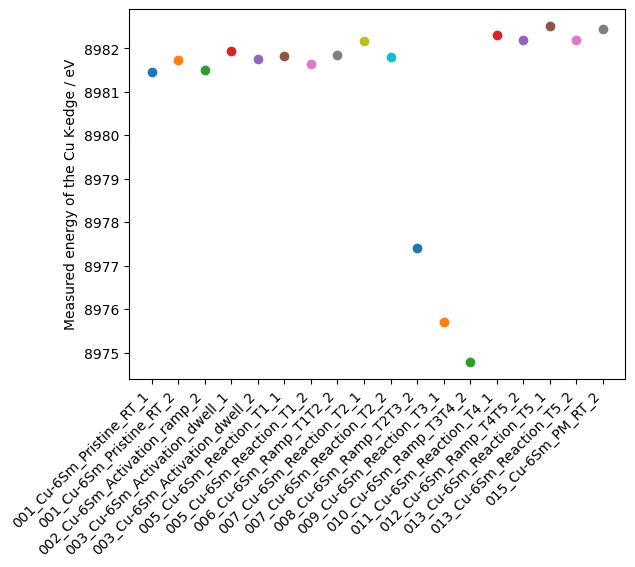

In [4]:
for (lab, en) in energ_calib_Cu_REF_list:
    plt.scatter(lab, en*1000)
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Cu K-edge / eV")
plt.savefig('Cu_REF_energy_shift.png')

### Plot Cu K-edge EXAFS

001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_1
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_1
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_1
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_1
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_1
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_1
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_1


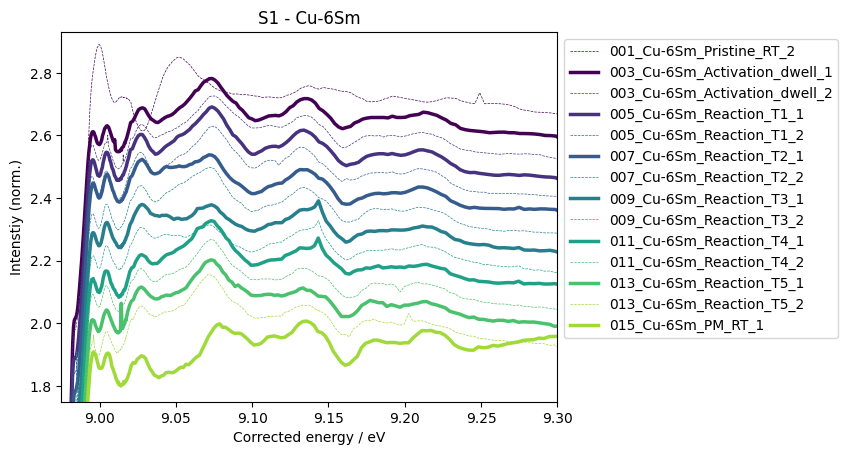

In [76]:
search_string = "Cu_K_EXAFS_merged"
var1="diode1"
var2="AS_IC"
monoE_min = 8.95
monoE_max = 9.2

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 2))  # Use the same color for pairs

    deltaE = idx*1e-3/len(labeled_files)
    x = -deltaE + result_df['monoE']
    y = -0.06*idx + np.exp((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
plt.ylim([1.75,2.93])
plt.xlim([8.975,9.3])
plt.xlabel ("Corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('Cu_EXAFS_S1.png')

001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_1
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_1
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_1
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_1
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_1
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_1
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_1


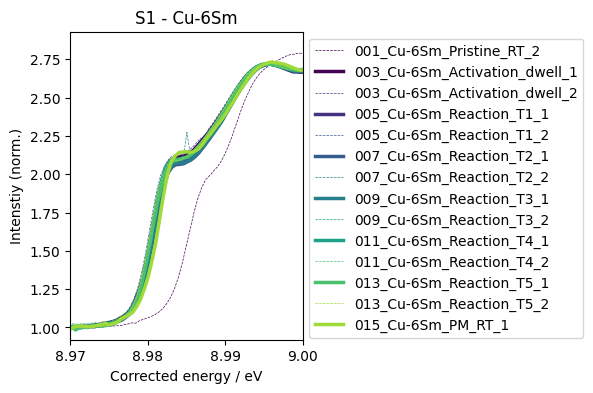

In [77]:
search_string = "Cu_K_EXAFS_merged"
var1="diode1"
var2="AS_IC"
monoE_min = 8.97
monoE_max = 8.996

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

plt.figure(figsize=(3, 4))
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 2))  # Use the same color for pairs

    deltaE = idx*1e-3/len(labeled_files)
    x = -deltaE + result_df['monoE']
    y = -0.0*idx + np.exp((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
plt.ylim([0.92,2.93])
plt.xlim([8.97,9.0])
plt.xlabel ("Corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('Cu_NEXAFS_S1.png')

### Plot Ce L3-edge NEXAFS

[('./001_Cu-6Sm_Pristine_RT/Data_Ce_L3_EXAFS_merged_scans_80_85.csv', '001_Cu-6Sm_Pristine_RT_2'), ('./003_Cu-6Sm_Activation_dwell/Data_Ce_L3_EXAFS_merged_scans_9_14.csv', '003_Cu-6Sm_Activation_dwell_2'), ('./005_Cu-6Sm_Reaction_T1/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '005_Cu-6Sm_Reaction_T1_2'), ('./007_Cu-6Sm_Reaction_T2/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '007_Cu-6Sm_Reaction_T2_2'), ('./009_Cu-6Sm_Reaction_T3/Data_Ce_L3_EXAFS_merged_scans_12_17.csv', '009_Cu-6Sm_Reaction_T3_2'), ('./011_Cu-6Sm_Reaction_T4/Data_Ce_L3_EXAFS_merged_scans_16_23.csv', '011_Cu-6Sm_Reaction_T4_2'), ('./013_Cu-6Sm_Reaction_T5/Data_Ce_L3_EXAFS_merged_scans_8_13.csv', '013_Cu-6Sm_Reaction_T5_2'), ('./015_Cu-6Sm_PM_RT/Data_Ce_L3_EXAFS_merged_scans_45_50.csv', '015_Cu-6Sm_PM_RT_2')]
001_Cu-6Sm_Pristine_RT_2
003_Cu-6Sm_Activation_dwell_2
005_Cu-6Sm_Reaction_T1_2
007_Cu-6Sm_Reaction_T2_2
009_Cu-6Sm_Reaction_T3_2
011_Cu-6Sm_Reaction_T4_2
013_Cu-6Sm_Reaction_T5_2
015_Cu-6Sm_PM_RT_2


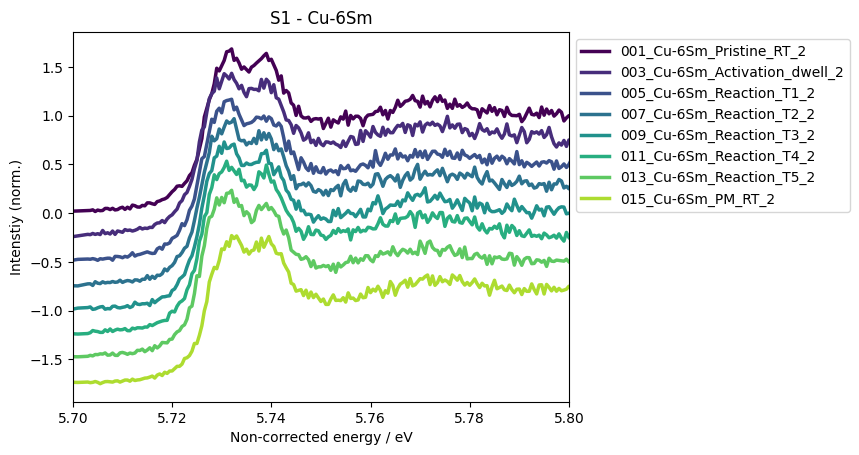

In [80]:
search_string = "Ce_L3_EXAFS_merged"
var1="roi1" # diode1
var2="mcaLt" # AS_IC
monoE_min = 5.68
monoE_max = 5.8

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 + 1}"
            labeled_files.append((file_path, label))
labeled_files.sort()
print (labeled_files)
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files))
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])

    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]

    color = cmap(norm(idx // 1))  # Use the same color for pairs

    x = result_df['monoE']
    y = -0.25*idx + ((result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min))
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)

    if label.endswith('_2'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_1'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=1.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xlim([5.7,5.8])
plt.xlabel ("Non-corrected energy / eV")
plt.ylabel ("Intenstiy (norm.)")
plt.title ("S1 - Cu-6Sm")

plt.savefig('Ce_NEXAFS_S1.png')